In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from diffusion_equation import compute_solution
from time import time
# from tqdm import trange
import pandas as pd
from sklearn.metrics import r2_score
import torch
from torch import nn
from torchvision import models

In [2]:
DEVICE = 'mps'

In [3]:
def flat_the_gradient_from_loss(model, loss):
    model.zero_grad()
    loss.backward(retain_graph=True)
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.detach().cpu().numpy().reshape(-1))
    grad_flat = np.concatenate(grads)
    return grad_flat

def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum


    # model.zero_grad()

    return w_ic, w_pde, w_data


# Getting data from simulator

In [4]:
# configuration of simulator
# and parametrs of reservouir
niter = 100
perm = np.load('/Users/kirill/Desktop/perm_2.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

t_final = 3.0
dt = t_final / niter

# Read from file

In [5]:
# sim_data: pres, swat, soil
sim_data = np.load("data-100-new-two-sigma/sim_100.npy").astype(np.float32)#[sim_nidexes]

pwat_list = np.load("data-100-new-two-sigma/pwat_100.npy").astype(np.float32)
poil_list = np.load("data-100-new-two-sigma/poil_100.npy").astype(np.float32)
kwat_list = np.load("data-100-new-two-sigma/kwat_100.npy").astype(np.float32)
koil_list = np.load("data-100-new-two-sigma/koil_100.npy").astype(np.float32)

In [6]:
koil_list.max(), koil_list.min()

(np.float32(0.3985206), np.float32(0.2001698))

In [7]:
niter = 100
nx, ny = 64, 64
t_final = 3.0
dt = t_final / niter
dx, dy = 1 / nx, 1 / ny

indexes_high = np.argwhere(sim_data[:, :, :, :, :, 1] > 0.1)
indexes_low = np.argwhere(sim_data[:, :, :, :, :, 1] > 0)

indexes_low = indexes_low[np.random.randint(0, len(indexes_low),len(indexes_high) // 2)]
indexes = np.vstack([indexes_low, indexes_high])

simulation_data = np.zeros((indexes.shape[0], 3))
for i, row in enumerate(indexes):
    simulation_data[i] = sim_data[row[0], row[1], row[2], row[3], row[4], :3]

x_list = indexes[:, 0] * dx
y_list = indexes[:, 1] * dy
t_list = indexes[:, 3] * dt

pwat_rand = pwat_list[indexes[:, -1]]
poil_rand = poil_list[indexes[:, -1]]
kwat_rand = kwat_list[indexes[:, -1]]
koil_rand = koil_list[indexes[:, -1]]

In [8]:
# rand_indexes_2000 = np.random.randint(0, simulation_data.shape[0], 2000)
# rand_indexes_1000 = np.random.randint(0, simulation_data.shape[0], 1000)
# rand_indexes_500 = np.random.randint(0, simulation_data.shape[0], 500)
# rand_indexes_250 = np.random.randint(0, simulation_data.shape[0], 250)

# np.save('train-indexes-2sigma-2000.npy', rand_indexes_2000)
# np.save('train-indexes-2sigma-1000.npy', rand_indexes_1000)
# np.save('train-indexes-2sigma-500.npy', rand_indexes_500)
# np.save('train-indexes-2sigma-250.npy', rand_indexes_250)


rand_indexes_2000 = np.load('train-indexes-2sigma-2000.npy')
rand_indexes_1000 = np.load('train-indexes-2sigma-1000.npy')
rand_indexes_500 = np.load('train-indexes-2sigma-500.npy')
rand_indexes_250 = np.load('train-indexes-2sigma-250.npy')

In [9]:
rand_indexes = rand_indexes_250

simulation_data_train = torch.tensor(simulation_data.astype(np.float32))[rand_indexes].requires_grad_(True)

x = torch.tensor(x_list.astype(np.float32))[rand_indexes].requires_grad_(True)
y = torch.tensor(y_list.astype(np.float32))[rand_indexes].requires_grad_(True)
t = torch.tensor(t_list.astype(np.float32))[rand_indexes].requires_grad_(True)


pwat = torch.tensor(pwat_rand.astype(np.float32))[rand_indexes]
poil = torch.tensor(poil_rand.astype(np.float32))[rand_indexes]
kwat = torch.tensor(kwat_rand.astype(np.float32))[rand_indexes]
koil = torch.tensor(koil_rand.astype(np.float32))[rand_indexes]

points = torch.stack((t, x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

In [10]:
pd.DataFrame(data=simulation_data_train.cpu().detach().numpy(), columns=['pres', 'swat', 'soil']).describe()

,pres,swat,soil
count,250.000000,2.500000e+02,250.000000
mean,0.825792,2.000208e-01,0.799979
std,0.300290,1.506403e-01,0.150640
min,0.003318,4.821364e-40,0.409828
25%,0.900916,4.735915e-04,0.682481
50%,0.973238,1.995453e-01,0.800455
75%,0.986547,3.175187e-01,0.999526
max,0.998812,5.901717e-01,1.000000


In [11]:
pres0_x1_points = torch.stack(
    (t, torch.zeros_like(x), y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

pres1_x1_points = torch.stack(
    (t, torch.ones_like(x), y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

swat0_x1_points = torch.stack(
    (torch.zeros_like(t), x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

soil0_x1_points = torch.stack(
    (torch.zeros_like(t), x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

u0_x2_points = torch.stack(
    (t, x, torch.zeros_like(y), pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

u1_x2_points = torch.stack(
    (t, x, torch.ones_like(y), pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

# Model configuration

In [12]:
class ModifiedPINN(nn.Module):
    """
    Modified MLP architecture based on Wang et al. with U-Net style connections.
    Particularly effective for capturing sharp gradients in pressure/saturation.
    
    Key improvements:
    - Modified MLP with U and V paths (proven effective for PINNs)
    - Skip connections for gradient flow
    - Separate branches for different physics (pressure vs saturation)
    - Adaptive activation functions
    """
    
    def __init__(self, input_dim=7, hidden_dim=128, num_layers=6, output_dim=7):
        super(ModifiedPINN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Modified MLP: Two parallel input branches (U and V paths)
        self.U = nn.Linear(input_dim, hidden_dim)
        self.V = nn.Linear(input_dim, hidden_dim)
        
        # Hidden layers with residual connections
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Learnable scaling parameters for outputs
        self.pressure_scale = nn.Parameter(torch.ones(1))
        self.saturation_scale = nn.Parameter(torch.ones(2))
        self.velocity_scale = nn.Parameter(torch.ones(4))
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Xavier initialization for better gradient flow."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """
        Forward pass with modified MLP architecture.
        
        Args:
            x: Input [batch, 7] -> (t, x, y, pwat, poil, kwat, koil)
        
        Returns:
            out: [batch, 7] -> (pres, soil, swat, uoil_x, uoil_y, uwat_x, uwat_y)
        """
        # Modified MLP: Two parallel branches
        U = torch.tanh(self.U(x))
        V = torch.tanh(self.V(x))
        
        # Element-wise multiplication (key feature of modified MLP)
        h = U * V
        
        # Pass through hidden layers with residual connections
        for i, layer in enumerate(self.hidden_layers):
            h_new = torch.tanh(layer(h))
            # Residual connection every 2 layers
            if i % 2 == 1 and i > 0:
                h = h + h_new  # Skip connection
            else:
                h = h_new
        
        # Output layer
        out = self.output_layer(h)
        
        # Split outputs
        pressure = out[:, 0:1]
        saturation_oil = out[:, 1:2]
        saturation_wat = out[:, 2:3]
        velocities = out[:, 3:7]
        
        # Apply constraints with learnable scales
        # Pressure: softplus for positivity
        pressure = F.softplus(pressure * self.pressure_scale, beta=1, threshold=20)
        
        # Saturations: sigmoid to enforce [0, 1] bounds
        saturation_oil = torch.sigmoid(saturation_oil * self.saturation_scale[0])
        saturation_wat = torch.sigmoid(saturation_wat * self.saturation_scale[1])
        
        # Enforce saturation constraint: S_o + S_w = 1
        # Normalize to ensure sum equals 1
        sat_sum = saturation_oil + saturation_wat + 1e-8
        saturation_oil = saturation_oil / sat_sum
        saturation_wat = saturation_wat / sat_sum
        
        # Velocities: can be positive or negative, use tanh scaled
        velocities = torch.tanh(velocities) * self.velocity_scale
        
        return torch.cat([pressure, saturation_oil, saturation_wat, velocities], dim=1)

# Differentiail equations, Loss function difinition

$$k_{water} = 1, k_{oil} = 0.3$$
$$x = (x_1, x_2)$$
$$ \phi(x) = 0.1 (poro)\\
k(x) = 1 (perm)$$

#### System of equation:

\begin{equation}
    \begin{cases}
        r_1(t, x) = 0.1 \frac{\partial s_{\text{water}}(t, x)}{\partial t} + div(u_{water}) = 0 \\
        r_2(t, x) = 0.1 \frac{\partial s_{\text{oil}}(t, x)}{\partial t} + div(u_{oil}) = 0 \\
        r_{3,x_1}(t, x) = u_{\text{water},x_1} + \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{3,x_2}(t, x) = u_{\text{water},x_2} + \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_{4, x_1}(t, x) = u_{\text{oil},x_1} + 0.1 \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{4, x_2}(t, x) = u_{\text{oil},x_2} + 0.1 \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_5(t, x) = s_{\text{water}}(t, x) + s_{\text{oil}}(t, x) - 1 = 0 \\
    \end{cases}
\end{equation}

#### Boundary condition
\begin{equation}
    \begin{cases}
        P(t, (0, x_2)) = (1, 1) \\
        P(t, (1, x_2)) = (0, 0) \\
        s_{\text{water}}(0, x) = (0, 0) \\
        s_{\text{oil}}(0, x) = (1, 1) \\
        u_{water/ oil}^{x_2}(t, x)\big|_{x_2=0} = u_{water/ oil}^{x_2}(t, x)\big|_{x_2=1} = 0
    \end{cases}
\end{equation}


#### Loss function:

\begin{equation}
    \label{eq:loss_term_0}
    \mathcal{R}_0(t, x) = r_1(t, x)^2 + r_2(t, x)^2 + r_3(t, x)^2 + r_4(t, x)^2 + r_5(t, x)^2
\end{equation}


\begin{equation}
    \label{eq:loss_term_1}
    \mathcal{R}_1(t, x) = \big(p(t, 0) - 1.0\big)^2 + \big(p(t, 1) - 0.0 \big)^2 + \big( s_{\text{oil}}(0, x) - 1.0 \big)^2 + \big( s_{\text{water}}(0, x) - 0.0 \big)^2
\end{equation}

\begin{split}
        \mathcal{R}_2(t, x) = \big( p_{\text{neural network}}(t, x) - p_{\text{simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{water, neural network}}(t, x) - s_{\text{water, simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{oil, neural network}}(t, x) - s_{\text{oil, simulation}}(t, x)\big)^2
\end{split}

#### Resultant function:

\begin{equation}
    \label{eq:loss_final}
    \mathcal{L} = w_0 \frac{1}{N} \mathcal{R}_0(t_i, x_i) + w_1 \frac{1}{N} \mathcal{R}_1(t_i, x_i) + w_2 \frac{1}{N} \mathcal{R}_2(t_i, x_i)
\end{equation} -->

# Model training

In [13]:
def get_plot_data(pwat=1.5, poil=2.0, kwat=1.5, koil = 0.3):
    perm = np.load('/Users/kirill/Desktop/perm_2.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    vr = 0.3
    
    if isinstance(pwat, float):
        pwat_list = pwat * torch.ones(64 * 64)
        poil_list = poil * torch.ones(64 * 64)
        kwat_list = kwat * torch.ones(64 * 64)
        koil_list = koil * torch.ones(64 * 64)

    pmin = 0.0
    pmax = 1.0

    dt = 0.15e-1
    niter = 100


    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    return pres, swat, soil

PRES, SWAT, SOIL = get_plot_data()

def plot_validation(model, pwat=1.5, poil=2.0, kwat=1.5, koil = 0.3):
    perm = np.load('/Users/kirill/Desktop/perm_2.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    vr = 0.3
    
    if isinstance(pwat, float):
        pwat_list = pwat * torch.ones(64 * 64)
        poil_list = poil * torch.ones(64 * 64)
        kwat_list = kwat * torch.ones(64 * 64)
        koil_list = koil * torch.ones(64 * 64)

    pmin = 0.0
    pmax = 1.0

    dt = 0.15e-1
    niter = 100

    pres, swat, soil = PRES, SWAT, SOIL
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)

    model_prediction = model(
        torch.stack(
            (time_for_model, 
             cartesian_points[:, 0], 
             cartesian_points[:, 1],
             pwat_list,
             poil_list,
             kwat_list,
             koil_list), -1).to(DEVICE))
    
    model_prediction = model_prediction.cpu().detach().numpy()
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    
    # 0,0 – Water saturation, simulator
    ax = axes[0, 0]
    im = ax.imshow(swat[:, :, :, -1])
    ax.set_title('Water saturation, simulator')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(im, ax=ax)
    
    # 0,1 – Water saturation, PINN
    ax = axes[0, 1]
    im = ax.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
    ax.set_title('Water saturation, PINN')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(im, ax=ax)
    
    # 0,2 – Pressure, simulator
    ax = axes[0, 2]
    im = ax.imshow(pres[:, :, :, -1])
    ax.set_title('Pressure, simulator')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(im, ax=ax)
    
    # 1,0 – Pressure, PINN
    ax = axes[1, 0]
    im = ax.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    ax.set_title('Pressure, PINN')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(im, ax=ax)
    
    # 1,1 – Water saturation at t = 0 (scatter)
    ax = axes[1, 1]
    ax.set_title('Water saturation at t = 0')
    ax.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    ax.scatter(
        np.linspace(0.0, 1.0, nx0),
        model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0],
        label='PINN'
    )
    ax.grid()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    
    # 1,2 – Pressure at t = 0 (scatter)
    ax = axes[1, 2]
    ax.set_title('Pressure at t = 0')
    ax.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    ax.scatter(
        np.linspace(0.0, 1.0, nx0),
        model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0],
        label='PINN'
    )
    ax.grid()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    
    fig.tight_layout()
    plt.show()

In [14]:
def get_batch_indices(total_size, batch_size, shuffle=True):
    """Generate batch indices for one epoch."""
    if shuffle:
        indices = torch.randperm(total_size)
    else:
        indices = torch.arange(total_size)
    
    for i in range(0, total_size, batch_size):
        yield indices[i:min(i + batch_size, total_size)]

In [15]:
def create_batches(data, batch_size, shuffle=True):
    """
    Create mini-batches from data.
    
    Args:
        data: Tensor of shape (N, features)
        batch_size: Size of each batch
        shuffle: Whether to shuffle data before batching
        
    Returns:
        List of batch indices
    """
    n_samples = data.shape[0]
    indices = torch.randperm(n_samples) if shuffle else torch.arange(n_samples)
    
    # Create batch indices
    batch_indices = []
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices.append(indices[start_idx:end_idx])
    
    return batch_indices

In [16]:
def resample_collocation_points(points, t, x, y, pwat, poil, kwat, koil, perm, device):
    """
    Resample collocation points for better coverage of the domain.
    This is important for PINNs to avoid overfitting to specific regions.
    
    Args:
        points: Current points tensor
        t, x, y, pwat, poil, kwat, koil: Domain parameters
        perm: Permeability data
        device: torch device
        
    Returns:
        New points tensor, updated perm_vec
    """
    # Resample with same distribution as original
    # You may want to implement adaptive sampling based on loss
    n_points = points.shape[0]
    
    # Assuming uniform sampling - modify based on your domain
    new_points = points.clone()
    # Add your resampling logic here
    
    new_perm_vec = torch.tensor(
        perm[list(x.cpu().detach().numpy().astype(int)), 
             list(y.cpu().detach().numpy().astype(int)), -1].astype(np.float32)
    ).to(device)
    
    return new_points, new_perm_vec

In [17]:
def compute_pde_residuals(model, points_batch, perm_vec_batch):
    """
    Compute PDE residuals with proper gradient tracking.
    
    KEY FIXES:
    1. Separate variable extraction with requires_grad=True
    2. Use retain_graph=True for multiple grad calls
    3. Ensure all tensors are on same device
    """
    
    # Extract components and ensure gradient tracking
    # CRITICAL: Must extract BEFORE forward pass and set requires_grad=True
    t = points_batch[:, 0:1].clone().detach().requires_grad_(True)
    x = points_batch[:, 1:2].clone().detach().requires_grad_(True)
    y = points_batch[:, 2:3].clone().detach().requires_grad_(True)
    
    # Other parameters (no gradients needed)
    pwat = points_batch[:, 3:4]
    poil = points_batch[:, 4:5]
    kwat = points_batch[:, 5:6]
    koil = points_batch[:, 6:7]
    
    # Reconstruct input with gradient-enabled variables
    model_input = torch.cat([t, x, y, pwat, poil, kwat, koil], dim=1)
    
    # Forward pass
    model_res = model(model_input)
    
    # Ones vector for gradient computation
    ones = torch.ones_like(model_res[:, 0], requires_grad=False)
    
    # ========================================================================
    # GRADIENT COMPUTATIONS WITH PROPER FLAGS
    # ========================================================================
    
    # Water saturation equation: ∂S_w/∂t + ∂u_wx/∂x + ∂u_wy/∂y = 0
    dswat_dt = torch.autograd.grad(
        outputs=model_res[:, 2],
        inputs=t,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=False  # Should be used
    )[0]
    
    duwat_x_dx = torch.autograd.grad(
        outputs=model_res[:, 5],
        inputs=x,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=False
    )[0]
    
    duwat_y_dy = torch.autograd.grad(
        outputs=model_res[:, 6],
        inputs=y,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=False
    )[0]
    
    r1 = 0.1 * dswat_dt + duwat_x_dx + duwat_y_dy
    
    # Oil saturation equation: ∂S_o/∂t + ∂u_ox/∂x + ∂u_oy/∂y = 0
    dsoil_dt = torch.autograd.grad(
        outputs=model_res[:, 1],
        inputs=t,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=False
    )[0]
    
    duoil_x_dx = torch.autograd.grad(
        outputs=model_res[:, 3],
        inputs=x,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=False
    )[0]
    
    duoil_y_dy = torch.autograd.grad(
        outputs=model_res[:, 4],
        inputs=y,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=False
    )[0]
    
    r2 = 0.1 * dsoil_dt + duoil_x_dx + duoil_y_dy
    
    # Darcy's law for water - x component
    dpres_dx = torch.autograd.grad(
        outputs=model_res[:, 0],
        inputs=x,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=False
    )[0]
    
    r3_x1 = model_res[:, 5] + kwat * perm_vec_batch * \
            model_res[:, 2]**pwat * dpres_dx
    
    # Darcy's law for water - y component
    dpres_dy = torch.autograd.grad(
        outputs=model_res[:, 0],
        inputs=y,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        allow_unused=False
    )[0]
    
    r3_x2 = model_res[:, 6] + kwat * perm_vec_batch * \
            model_res[:, 2]**pwat * dpres_dy
    
    # Darcy's law for oil - x component (reuse dpres_dx)
    r4_x1 = model_res[:, 3] + koil * (1/3) * perm_vec_batch * \
            model_res[:, 1]**poil * dpres_dx
    
    # Darcy's law for oil - y component (reuse dpres_dy)
    r4_x2 = model_res[:, 4] + koil * (1/3) * perm_vec_batch * \
            model_res[:, 1]**poil * dpres_dy
    
    # Saturation constraint: S_w + S_o = 1
    r5 = model_res[:, 2] + model_res[:, 1] - ones
    
    return r1, r2, r3_x1, r3_x2, r4_x1, r4_x2, r5, model_res


def get_batch_indices(total_size, batch_size, shuffle=True):
    """Generate batch indices."""
    if shuffle:
        indices = torch.randperm(total_size)
    else:
        indices = torch.arange(total_size)
    
    for i in range(0, total_size, batch_size):
        yield indices[i:min(i + batch_size, total_size)]

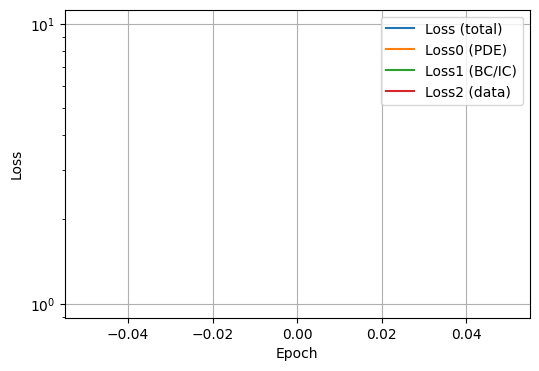

In [18]:
epochs_hist = []
loss_hist   = []
loss0_hist  = []
loss1_hist  = []
loss2_hist  = []

# ONE figure & ONE axes
fig, ax = plt.subplots(figsize=(6, 4))

(line_loss,)  = ax.plot([], [], label="Loss (total)")
(line_l0,)    = ax.plot([], [], label="Loss0 (PDE)")
(line_l1,)    = ax.plot([], [], label="Loss1 (BC/IC)")
(line_l2,)    = ax.plot([], [], label="Loss2 (data)")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.grid(True)
ax.legend()

def update_loss_plot(epoch, loss, loss0, loss1, loss2):
    # store history
    epochs_hist.append(epoch)
    loss_hist.append(loss)
    loss0_hist.append(loss0)
    loss1_hist.append(loss1)
    loss2_hist.append(loss2)

    # update line data
    line_loss.set_data(epochs_hist, loss_hist)
    line_l0.set_data(epochs_hist, loss0_hist)
    line_l1.set_data(epochs_hist, loss1_hist)
    line_l2.set_data(epochs_hist, loss2_hist)

    # rescale
    ax.relim()
    ax.autoscale_view()

    clear_output(wait=True)
    display(fig)

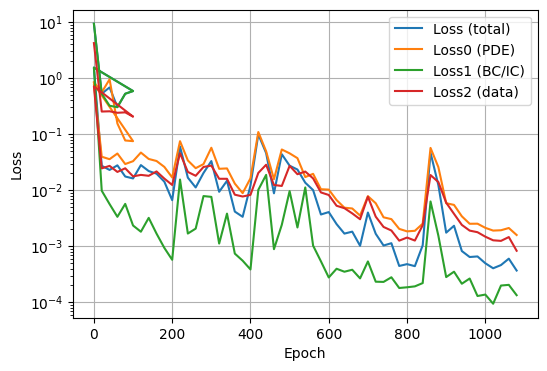

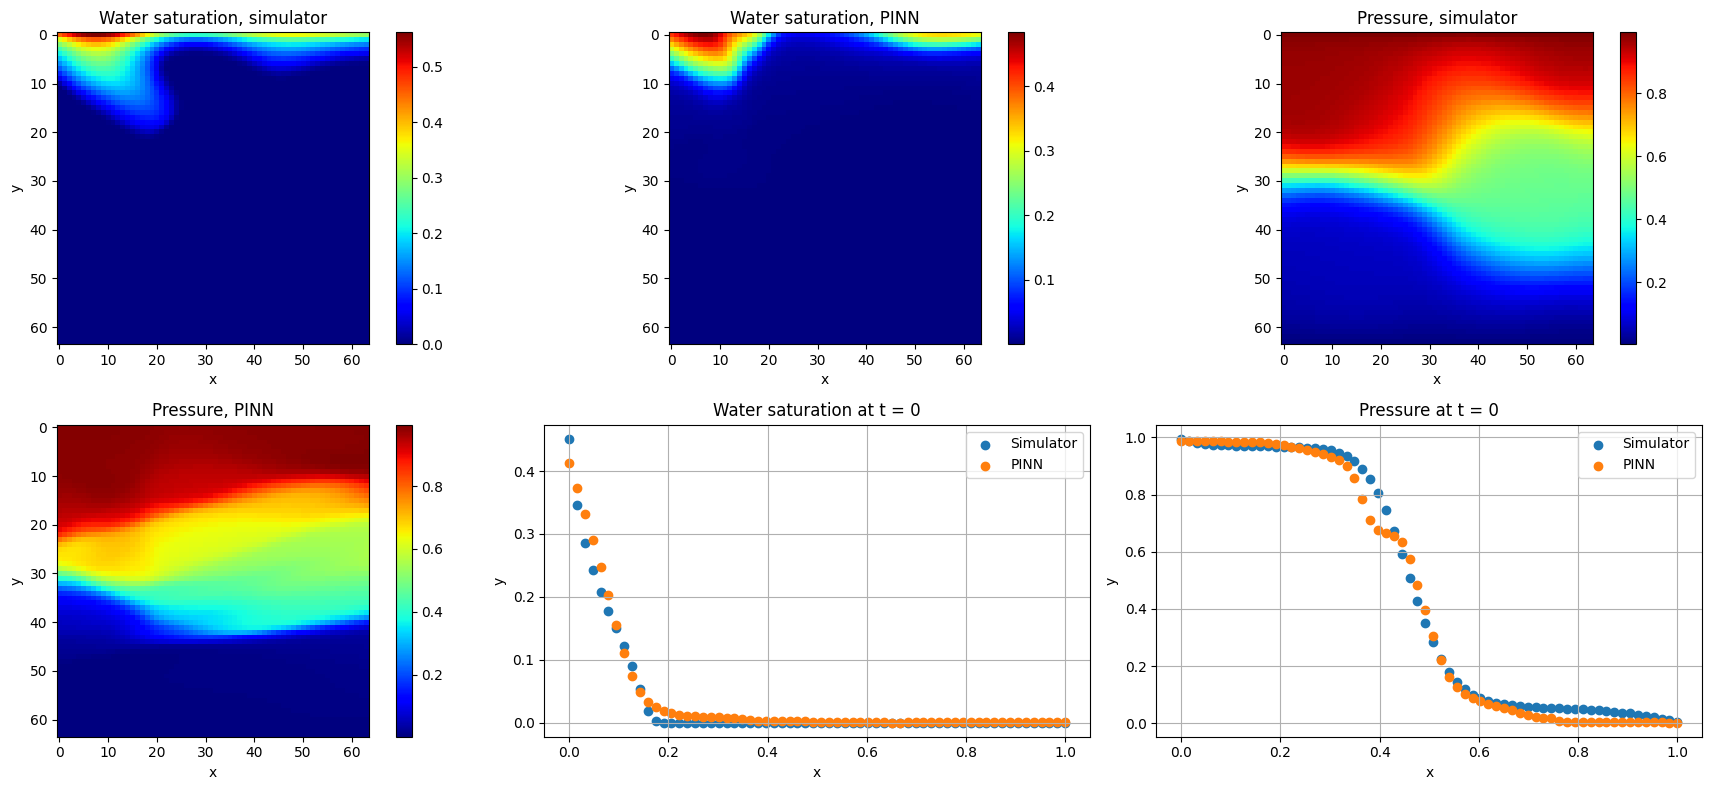

KeyboardInterrupt: 

In [57]:
epochs = 5_000
BATCH_SIZE = 70  
RESAMPLE_EVERY = 70

# model = pinn_model().to(DEVICE)
model = ModifiedPINN(
   input_dim=7,
   hidden_dim=128,  # Try 128, 256
   num_layers=6,    # Try 5-8
   output_dim=7
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
max_dist = float('inf')

# Initialize permeability vector
perm_vec = torch.tensor(
    perm[list(x.cpu().detach().numpy().astype(int)), 
         list(y.cpu().detach().numpy().astype(int)), -1].astype(np.float32)
).to(DEVICE)


# ============================================================================
# MAIN TRAINING LOOP WITH BATCHING (FIXED)
# ============================================================================

for cur_epoch in trange(epochs):
    
    epoch_loss = 0.0
    epoch_loss0 = 0.0
    epoch_loss1 = 0.0
    epoch_loss2 = 0.0
    num_batches = 0
    
    # ========================================================================
    # MINI-BATCH TRAINING
    # ========================================================================
    for batch_indices in get_batch_indices(points.shape[0], BATCH_SIZE, shuffle=True):
        
        optimizer.zero_grad()
        
        # Get batch data
        points_batch = points[batch_indices].to(DEVICE)
        perm_vec_batch = perm_vec[batch_indices]
        
        # --------------------------------------------------------------------
        # PDE RESIDUALS - Using fixed function
        # --------------------------------------------------------------------
        r1, r2, r3_x1, r3_x2, r4_x1, r4_x2, r5, model_res = \
            compute_pde_residuals(model, points_batch, perm_vec_batch)
        
        # PDE loss
        loss0 = torch.mean(
            r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + r4_x1**2 + r4_x2**2 + r5**2
        )
        
        # --------------------------------------------------------------------
        # BOUNDARY CONDITIONS - Sample subset
        # --------------------------------------------------------------------
        bc_batch_size = min(BATCH_SIZE // 4, 
                           pres0_x1_points.shape[0],
                           pres1_x1_points.shape[0],
                           soil0_x1_points.shape[0],
                           swat0_x1_points.shape[0])
        
        bc_idx_pres0 = torch.randperm(pres0_x1_points.shape[0])[:bc_batch_size]
        bc_idx_pres1 = torch.randperm(pres1_x1_points.shape[0])[:bc_batch_size]
        bc_idx_soil0 = torch.randperm(soil0_x1_points.shape[0])[:bc_batch_size]
        bc_idx_swat0 = torch.randperm(swat0_x1_points.shape[0])[:bc_batch_size]
        
        # Get predictions at boundary points
        press0 = model(pres0_x1_points[bc_idx_pres0].to(DEVICE))[:, 0]
        press1 = model(pres1_x1_points[bc_idx_pres1].to(DEVICE))[:, 0]
        soil0 = model(soil0_x1_points[bc_idx_soil0].to(DEVICE))[:, 1]
        swat0 = model(swat0_x1_points[bc_idx_swat0].to(DEVICE))[:, 2]
        
        # Boundary condition loss
        loss1 = torch.mean(
            (press0 - 1.0)**2 + press1**2 + 
            (soil0 - 1.0)**2 + swat0**2
        )
        
        # --------------------------------------------------------------------
        # DATA LOSS - Sample from simulation data
        # --------------------------------------------------------------------
        data_batch_size = min(BATCH_SIZE, simulation_data_train.shape[0])
        data_indices = torch.randperm(simulation_data_train.shape[0])[:data_batch_size]
        
        # Get corresponding points and simulation data
        data_points = points[data_indices].to(DEVICE)
        sim_data = simulation_data_train[data_indices].to(DEVICE)
        
        # Model predictions on data points
        model_res_data = model(data_points)
        
        # Data loss
        loss2 = torch.mean(
            (model_res_data[:, 0] - sim_data[:, 0])**2 + 
            (model_res_data[:, 2] - sim_data[:, 1])**2 + 
            (model_res_data[:, 1] - sim_data[:, 2])**2
        )
        
        # --------------------------------------------------------------------
        # DYNAMIC WEIGHTS
        # --------------------------------------------------------------------
        w_ic, w_pde, w_data = compute_weights_grad_orthogonal_autograd(
            model, loss1, loss0, loss2, kappa=15.0
        )
        
        # Combined loss
        loss = w_pde * loss0 + w_ic * loss1 + w_data * loss2
        
        # --------------------------------------------------------------------
        # BACKWARD PASS
        # --------------------------------------------------------------------
        loss.backward()
        
        # Optional: Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Accumulate losses
        epoch_loss += loss.item()
        epoch_loss0 += loss0.item()
        epoch_loss1 += loss1.item()
        epoch_loss2 += loss2.item()
        num_batches += 1
    
    # ========================================================================
    # EPOCH SUMMARY
    # ========================================================================
    epoch_loss /= num_batches
    epoch_loss0 /= num_batches
    epoch_loss1 /= num_batches
    epoch_loss2 /= num_batches
    
    dist = epoch_loss0 + epoch_loss1 + epoch_loss2
    
    # Visualization
    if cur_epoch % 20 == 0:
        update_loss_plot(cur_epoch, epoch_loss, epoch_loss0, epoch_loss1, epoch_loss2)
        plot_validation(model)
    
    # Save best model
    if dist < max_dist:
        torch.save(model.state_dict(), 'pinn-test4-250-batched-new.pth')
        max_dist = dist
    
    # Learning rate decay
    if cur_epoch % 300 == 0 and cur_epoch > 0:
        optimizer.param_groups[0]['lr'] *= 0.8

In [18]:
## x - vector (pres
#             soil,
#             swat,
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)


# 0 - pres, 1 - swat, 2 - soil

In [19]:
model = ModifiedPINN(
   input_dim=7,
   hidden_dim=128,  # Try 128, 256
   num_layers=6,    # Try 5-8
   output_dim=7
).to(DEVICE)

model.load_state_dict(torch.load('pinn-test4-250-batched.pth'))

<All keys matched successfully>

In [32]:
# def main_new(model, pwat=1.5, poil=2.0, kwat=1.5, koil = 0.3):
#     perm = np.load('/Users/kirill/Desktop/perm_2.npy')
#     nx0, nx1 = perm.shape
#     nx2 = 1
#     perm = np.reshape(perm, (nx0, nx1, nx2))
#     poro = 0.1 + np.zeros((nx0, nx1, nx2))

#     dx0 = 1.0 / nx0
#     dx1 = 1.0 / nx1
#     dx2 = 1.0 / nx2
#     vr = 0.3
    
#     if isinstance(pwat, float):
#         pwat_list = pwat * torch.ones(64 * 64)
#         poil_list = poil * torch.ones(64 * 64)
#         kwat_list = kwat * torch.ones(64 * 64)
#         koil_list = koil * torch.ones(64 * 64)

#     pmin = 0.0
#     pmax = 1.0

#     dt = 0.15e-1
#     niter = 100


#     swat = np.zeros((nx0, nx1, nx2))
#     soil = np.ones((nx0, nx1, nx2))


#     pres, swat, soil = compute_solution(perm, poro,
#                                         dx0, dx1, dx2, dt * niter, niter,
#                                         pwat, kwat, poil, koil, vr,
#                                         pmin=0.0, pmax=1.0)
    
#     time_for_model = (niter * dt) * torch.ones(64 * 64)
#     x_for_model = dx0 * torch.arange(64)
#     y_for_model = dx1 * torch.arange(64)
#     cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)

#     model_prediction = model(
#         torch.stack(
#             (time_for_model, 
#              cartesian_points[:, 0], 
#              cartesian_points[:, 1],
#              pwat_list,
#              poil_list,
#              kwat_list,
#              koil_list), -1).to(DEVICE))
    
#     model_prediction = model_prediction.cpu().detach().numpy()
    
    
    
#     plt.figure()
#     plt.title('Water saturation, simulator')
#     plt.imshow(swat[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('test_num_4/color_swat_sim.png')
#     plt.show()
    
#     plt.figure()
#     plt.title('Water saturation, PINN')
#     plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('test_num_4/color_swat_pinn4.png')
#     plt.show()
    
#     plt.figure()
#     plt.title('Pressure, simulator')
#     plt.imshow(pres[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('test_num_4/color_pressure_sim.png')
#     plt.show()
    

#     plt.figure()
#     plt.title('Pressure, PINN')
#     plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('test_num_4/color_pressure_pinn4.png')
#     plt.show()    
    
    
#     plt.figure()
#     plt.title('Water saturation at t = 0')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('test_num_4/swat_scatter4.png')
#     plt.show()


#     plt.figure()
#     plt.title('Pressure at t = 0')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('test_num_4/pres_scatter4.png')
#     plt.show()

#     return 0

def set_big_plot_style(scale: float = 1.2):
    """Global matplotlib style for bigger text/ticks/legend and sharper saved figs."""
    base = 18 * scale
    title = 22 * scale
    label = 20 * scale
    ticks = 16 * scale
    legend = 16 * scale

    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,

        "font.size": base,
        "axes.titlesize": title,
        "axes.labelsize": label,
        "xtick.labelsize": ticks,
        "ytick.labelsize": ticks,
        "legend.fontsize": legend,

        "axes.titlepad": 12,
        "axes.labelpad": 10,
    })

def _add_colorbar_big(im):
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=plt.rcParams.get("ytick.labelsize", 16))
    return cbar

def main_new(model, pwat=1.5, poil=2.0, kwat=1.5, koil=0.3):
    # ---- make ALL plot text bigger ----
    set_big_plot_style(scale=1.3)  # try 1.0 .. 1.6

    perm = np.load('/Users/kirill/Desktop/perm_2.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    vr = 0.3

    # total number of spatial points used for the PINN query
    npts = nx0 * nx1

    # Make constant property fields if floats are provided
    if isinstance(pwat, float):
        pwat_list = pwat * torch.ones(npts)
        poil_list = poil * torch.ones(npts)
        kwat_list = kwat * torch.ones(npts)
        koil_list = koil * torch.ones(npts)
    else:
        # If you pass tensors/arrays, ensure they are flattened to length npts
        pwat_list = torch.as_tensor(pwat).reshape(-1)[:npts]
        poil_list = torch.as_tensor(poil).reshape(-1)[:npts]
        kwat_list = torch.as_tensor(kwat).reshape(-1)[:npts]
        koil_list = torch.as_tensor(koil).reshape(-1)[:npts]

    pmin = 0.0
    pmax = 1.0

    dt = 0.15e-1
    niter = 100

    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))

    pres, swat, soil = compute_solution(
        perm, poro,
        dx0, dx1, dx2, dt * niter, niter,
        pwat, kwat, poil, koil, vr,
        pmin=pmin, pmax=pmax
    )

    # Build inputs for the model: (t, x, y, pwat, poil, kwat, koil)
    time_for_model = (niter * dt) * torch.ones(npts)
    x_for_model = dx0 * torch.arange(nx0)
    y_for_model = dx1 * torch.arange(nx1)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)  # (npts, 2)

    X = torch.stack(
        (
            time_for_model,
            cartesian_points[:, 0],
            cartesian_points[:, 1],
            pwat_list,
            poil_list,
            kwat_list,
            koil_list,
        ),
        dim=-1
    ).to(DEVICE)

    model_prediction = model(X).detach().cpu().numpy()

    # Convenience arrays for plotting (squeeze nx2=1)
    swat_sim_2d = np.squeeze(swat[:, :, 0, -1])   # (nx0, nx1)
    pres_sim_2d = np.squeeze(pres[:, :, 0, -1])   # (nx0, nx1)

    swat_pinn_2d = np.squeeze(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, :, 0])
    pres_pinn_2d = np.squeeze(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, :, 0])

    # ---- Plots ----
    # Water saturation, simulator
    plt.figure(figsize=(8, 6))
    plt.title('Water saturation, simulator')
    im = plt.imshow(swat_sim_2d)
    _add_colorbar_big(im)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('test_num_4/color_swat_sim.png', bbox_inches="tight")
    plt.show()

    # Water saturation, PINN
    plt.figure(figsize=(8, 6))
    plt.title('Water saturation, PINN')
    im = plt.imshow(swat_pinn_2d)
    _add_colorbar_big(im)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('test_num_4/color_swat_pinn4.png', bbox_inches="tight")
    plt.show()

    # Pressure, simulator
    plt.figure(figsize=(8, 6))
    plt.title('Pressure, simulator')
    im = plt.imshow(pres_sim_2d)
    _add_colorbar_big(im)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('test_num_4/color_pressure_sim.png', bbox_inches="tight")
    plt.show()

    # Pressure, PINN
    plt.figure(figsize=(8, 6))
    plt.title('Pressure, PINN')
    im = plt.imshow(pres_pinn_2d)
    _add_colorbar_big(im)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('test_num_4/color_pressure_pinn4.png', bbox_inches="tight")
    plt.show()

    # Water saturation scatter (using your original slice logic)
    plt.figure(figsize=(8, 6))
    plt.title('Water saturation at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0),
                model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0],
                label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.savefig('test_num_4/swat_scatter4.png', bbox_inches="tight")
    plt.show()

    # Pressure scatter (using your original slice logic)
    plt.figure(figsize=(8, 6))
    plt.title('Pressure at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0),
                model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0],
                label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.savefig('test_num_4/pres_scatter4.png', bbox_inches="tight")
    plt.show()

    return 0


In [33]:
pd.DataFrame(model(points).cpu().detach().numpy(), columns=['pres', 'soil', 'swat', 'uoil_x', 'uoil_y', 'uwat_x', 'uwat_y']).describe()

,pres,soil,swat,uoil_x,uoil_y,uwat_x,uwat_y
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.835445,0.802053,0.197947,0.014179,0.002711,0.021309,0.004265
std,0.311729,0.144673,0.144673,0.003040,0.000494,0.004744,0.001594
min,0.002674,0.427528,0.000013,0.010863,0.001626,0.001884,-0.004288
25%,0.937300,0.685248,0.070465,0.012073,0.002386,0.022107,0.004316
50%,0.984660,0.801529,0.198471,0.012881,0.002613,0.023388,0.004747
75%,0.990870,0.929535,0.314752,0.015071,0.003009,0.023764,0.004956
max,1.002605,0.999987,0.572472,0.020651,0.003766,0.024284,0.005670


In [34]:
pd.DataFrame(simulation_data_train.cpu().detach().numpy(), columns=['pres', 'swat', 'soil']).describe()

,pres,swat,soil
count,250.000000,2.500000e+02,250.000000
mean,0.825792,2.000208e-01,0.799979
std,0.300290,1.506403e-01,0.150640
min,0.003318,4.821364e-40,0.409828
25%,0.900916,4.735915e-04,0.682481
50%,0.973238,1.995453e-01,0.800455
75%,0.986547,3.175187e-01,0.999526
max,0.998812,5.901717e-01,1.000000


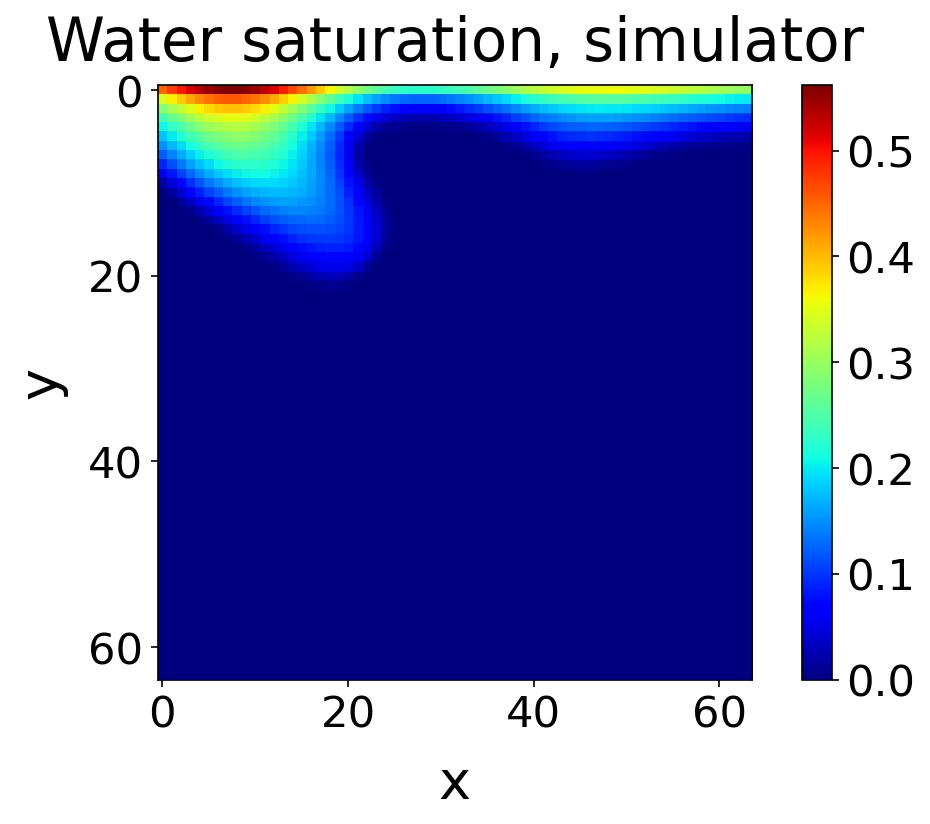

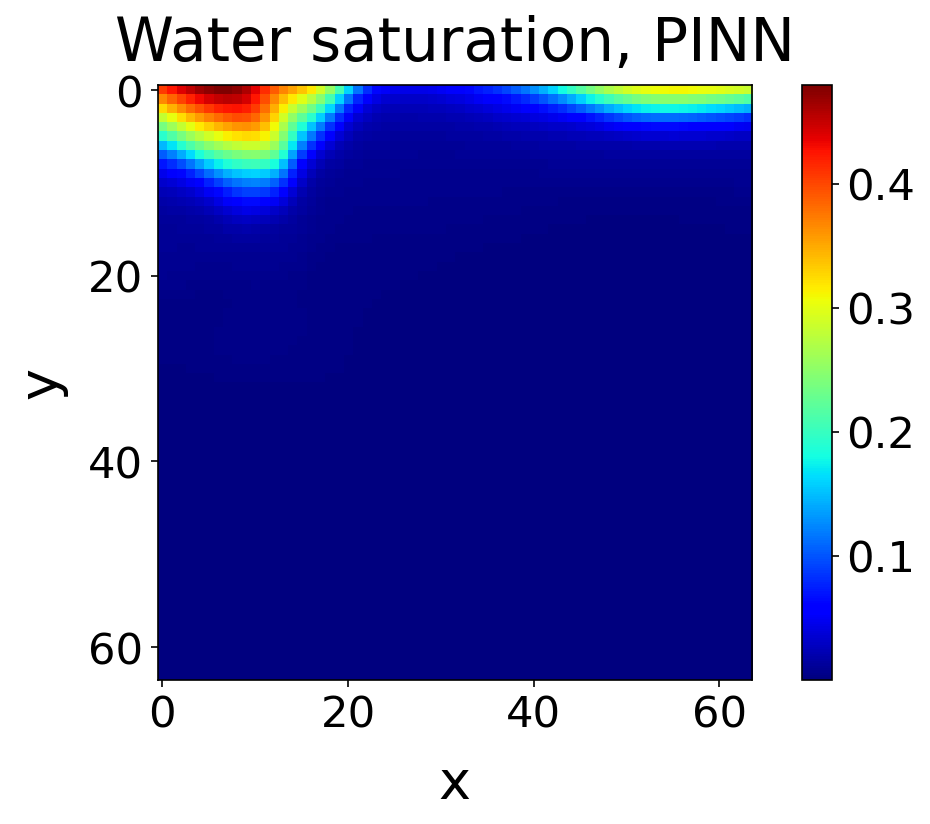

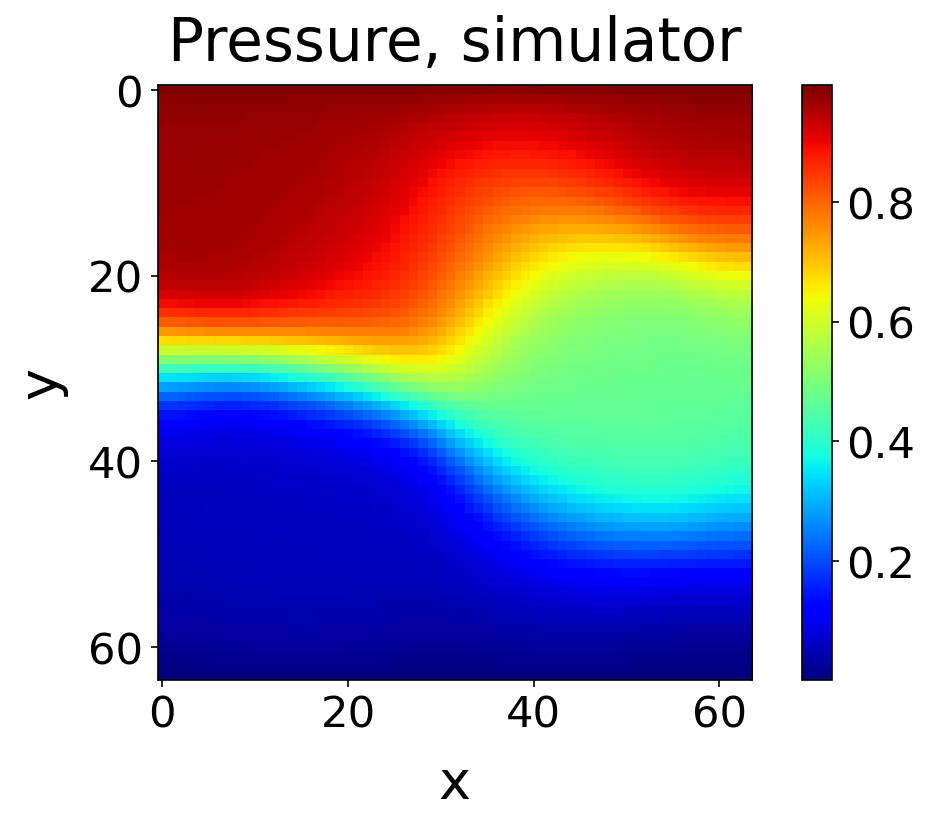

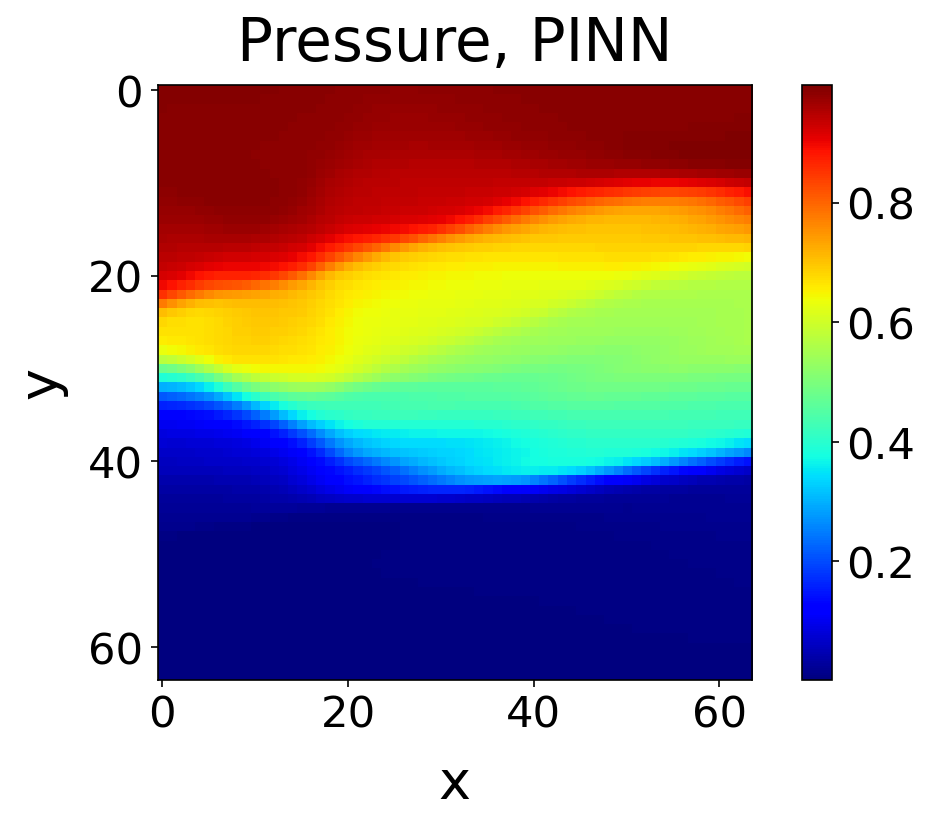

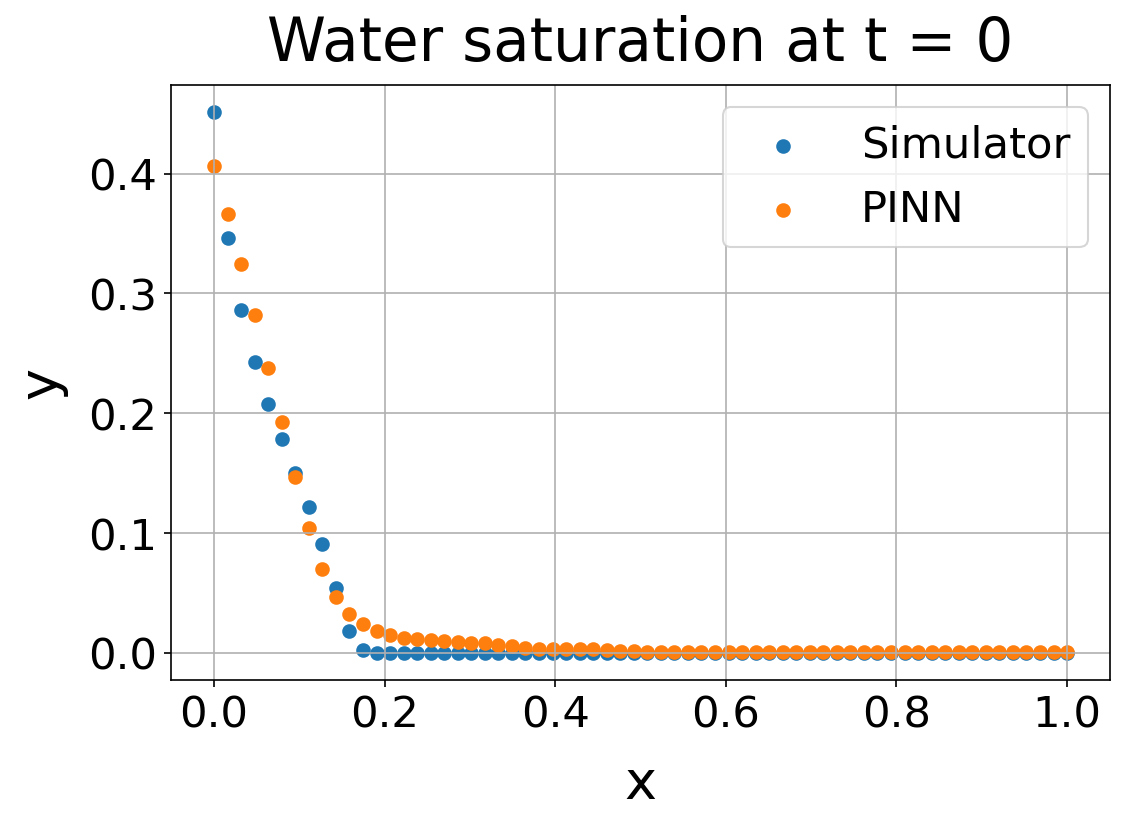

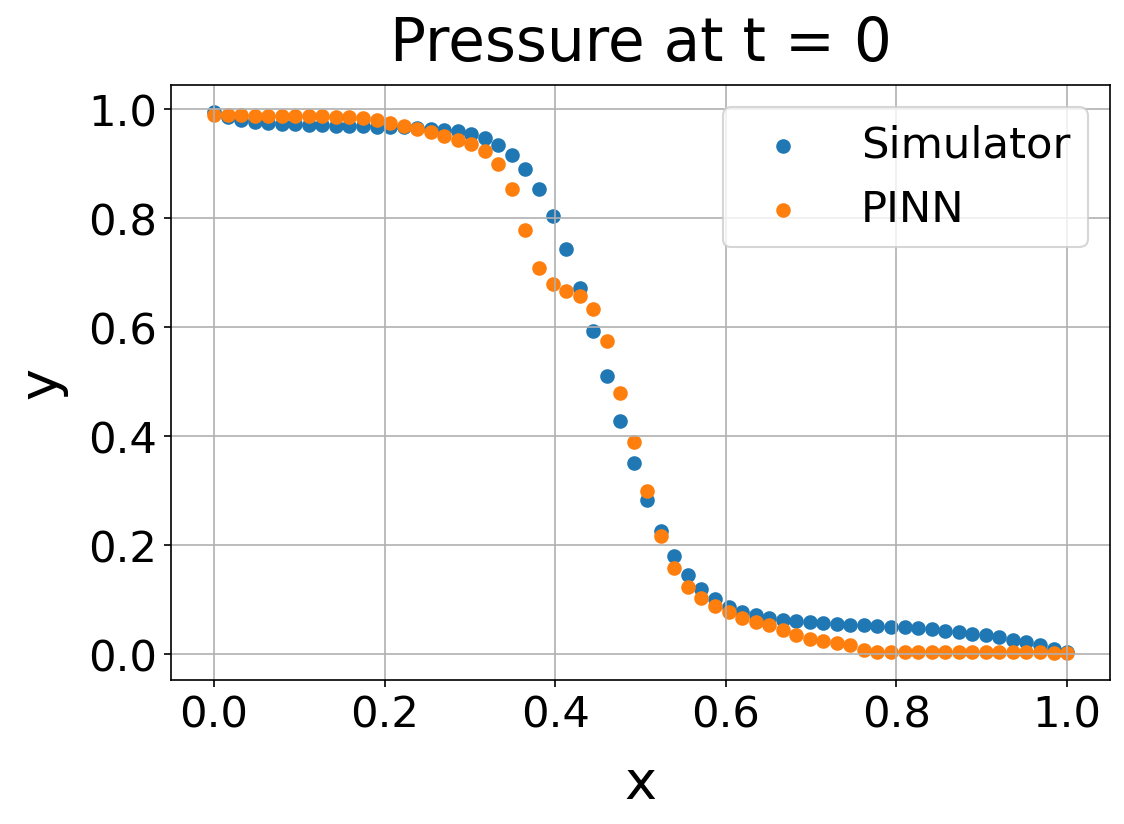

0

In [35]:
# model = pinn_model().to(DEVICE)
# model.load_state_dict(torch.load('pinn-test4-500.pth'))
model.eval()

main_new(model)

# Test results random from simulation

In [30]:
def build_metrics(model_prediction, pres, swat, soil, process):

    metrics = ['MSE', 'MAE', 'R_2', 'RMSE', 'MAPE']
    
    # Saturation water
    satur = [
        np.mean((model_prediction[:, 2] - swat) ** 2),  # MSE
        np.mean(np.abs(model_prediction[:, 2] - swat)), # MAE
        r2_score(swat, model_prediction[:, 2]),         # R^2
        np.sqrt(np.mean((model_prediction[:, 2] - swat) ** 2)), # RMSE
        np.mean(np.abs((swat - model_prediction[:, 2]) / (swat + 1e-8))) * 100  # MAPE (%)
    ]
    
    # Pressure
    press = [
        np.mean((model_prediction[:, 0] - pres) ** 2),
        np.mean(np.abs(model_prediction[:, 0] - pres)),
        r2_score(pres, model_prediction[:, 0]),
        np.sqrt(np.mean((model_prediction[:, 0] - pres) ** 2)),
        np.mean(np.abs((pres - model_prediction[:, 0]) / (pres + 1e-8))) * 100
    ]
    
    # Saturation oil
    sat_oil = [
        np.mean((model_prediction[:, 1] - soil) ** 2),
        np.mean(np.abs(model_prediction[:, 1] - soil)),
        r2_score(soil, model_prediction[:, 1]),
        np.sqrt(np.mean((model_prediction[:, 1] - soil) ** 2)),
        np.mean(np.abs((soil - model_prediction[:, 1]) / (soil + 1e-8))) * 100
    ]
    
    # Combine into dataframe
    metrics_df = pd.DataFrame({
        f'Metrics {process}': metrics,
        f'Saturation water {process}': satur,
        f'Saturation oil {process}': sat_oil,
        f'Pressure {process}': press
    })
    
    return metrics_df


In [31]:
def build_test_random(model, x_list=x_list, y_list=y_list, 
               t_list=t_list, pwat_rand=pwat_rand,
               poil_rand=poil_rand, kwat_rand=kwat_rand, 
               koil_rand=koil_rand, simulation_data=simulation_data, 
               dx=dx, dy=dy, dt=dt, rand_indexes=rand_indexes, test_size=100):

    N = simulation_data.shape[0] - rand_indexes.shape[0]
    test_indexes = np.random.randint(0, N, test_size)
    pres = np.delete(simulation_data[:, 0], rand_indexes)[test_indexes]
    swat = np.delete(simulation_data[:, 1], rand_indexes)[test_indexes]
    soil = np.delete(simulation_data[:, 2], rand_indexes)[test_indexes]

    x_list = np.delete(x_list, rand_indexes)[test_indexes] * dx
    y_list = np.delete(y_list, rand_indexes)[test_indexes] * dy
    t_list = np.delete(t_list, rand_indexes)[test_indexes] * dt

    pwat_rand = np.delete(pwat_rand, rand_indexes)[test_indexes]
    poil_rand = np.delete(poil_rand, rand_indexes)[test_indexes]
    kwat_rand = np.delete(kwat_rand, rand_indexes)[test_indexes]
    koil_rand = np.delete(koil_rand, rand_indexes)[test_indexes]

    # Build (N, 7) input matrix
    X = np.column_stack([
        t_list.astype(np.float32),
        x_list.astype(np.float32),
        y_list.astype(np.float32),
        pwat_rand.astype(np.float32),
        poil_rand.astype(np.float32),
        kwat_rand.astype(np.float32),
        koil_rand.astype(np.float32),
    ])

    with torch.no_grad():
        X_t = torch.from_numpy(X).to(DEVICE)      # (N, 7)
        model_prediction = model(X_t).cpu().numpy()

    return model_prediction, pres, swat, soil


In [32]:
model_prediction, pres, swat, soil = build_test_random(model)
build_metrics(model_prediction, pres, swat, soil, 'test random')

,Metrics test random,Saturation water test random,Saturation oil test random,Pressure test random
0,MSE,4.689386e-02,0.046894,0.093519
1,MAE,1.782735e-01,0.178274,0.164742
2,R_2,-1.867163e+00,-1.867163,-0.441096
3,RMSE,2.165499e-01,0.216550,0.305809
4,MAPE,1.019659e+07,24.821873,93.196105


# Test result real sim

In [33]:
def build_test_sim(model, dt=0.15e-1, niter=100, 
                   perm=perm, dx=dx, dy=dy,
                   pwat=1.5, poil=2.0, 
                   kwat=1.5, koil=0.3,
                   vr=0.3):
    
    pwat_list = pwat * torch.ones(64 * 64)
    poil_list = poil * torch.ones(64 * 64)
    kwat_list = kwat * torch.ones(64 * 64)
    koil_list = koil * torch.ones(64 * 64)
    
    
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))
    
    
    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    
    model_prediction = model(
        torch.stack(
            (time_for_model, 
             cartesian_points[:, 0], 
             cartesian_points[:, 1],
             pwat_list,
             poil_list,
             kwat_list,
             koil_list), -1).to(DEVICE))
    
    model_prediction = model_prediction.cpu().detach().numpy()

    return model_prediction, pres, swat, soil

In [34]:
model_prediction, pres, swat, soil = build_test_sim(model, dt=0.15e-1, niter=100,)


sw_pred = model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]
sw_true = swat[:, 0, 0, -1]

so_pred = model_prediction[:, 1].reshape(nx0, nx1, nx2)[:, 0, 0]
so_true = soil[:, 0, 0, -1]

p_pred  = model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]
p_true  = pres[:, 0, 0, -1]

metrics = ['MSE', 'MAE', 'R_2', 'RMSE', 'MAPE']

# Helper to compute all metrics with safe MAPE
def all_metrics(y_true, y_pred, eps=1e-8):
    mse  = np.mean((y_pred - y_true) ** 2)
    mae  = np.mean(np.abs(y_pred - y_true))
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0
    return [mse, mae, r2, rmse, mape]

# Build columns
satur = all_metrics(sw_true, sw_pred)   # Saturation water
sat_oil = all_metrics(so_true, so_pred)   # Saturation oil
press = all_metrics(p_true,  p_pred)    # Pressure

# Combine into dataframe
metrics_df = pd.DataFrame({
    f'Metrics test': metrics,
    f'Saturation test': satur,
    f'Saturation oil test': sat_oil,
    f'Pressure test': press
})

metrics_df

,Metrics test,Saturation test,Saturation oil test,Pressure test
0,MSE,1.466211e-04,0.000147,0.001589
1,MAE,6.459493e-03,0.006459,0.028886
2,R_2,9.817963e-01,0.981796,0.991137
3,RMSE,1.210872e-02,0.012109,0.039858
4,MAPE,1.769422e+07,0.789714,30.647792


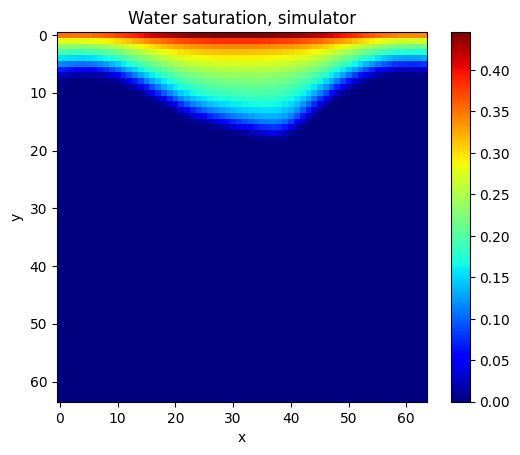

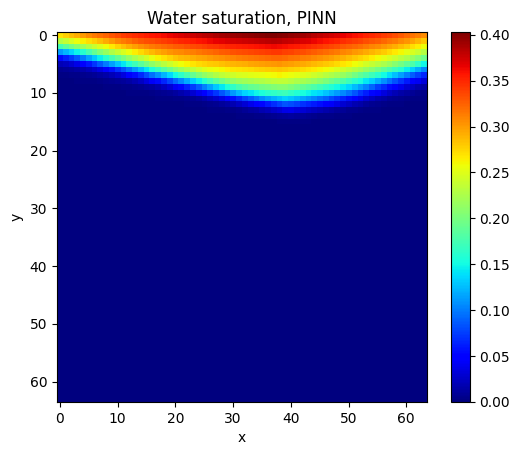

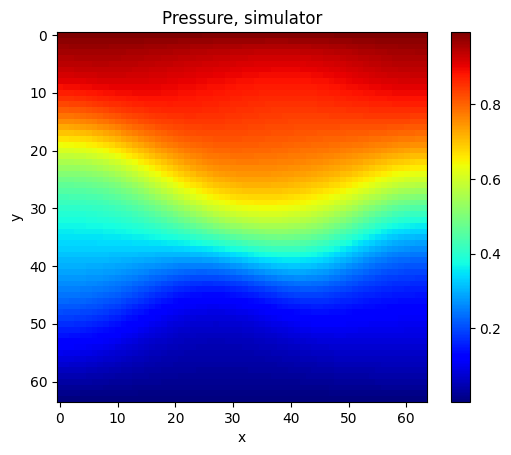

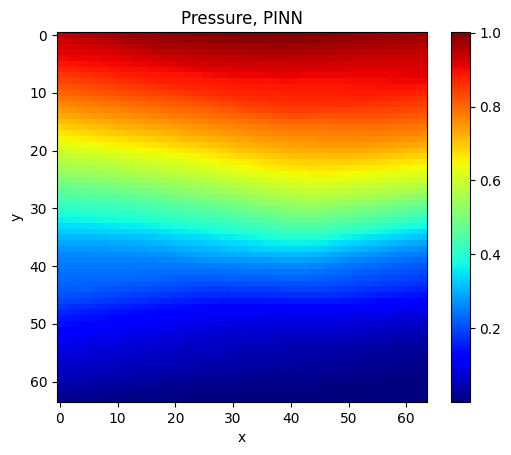

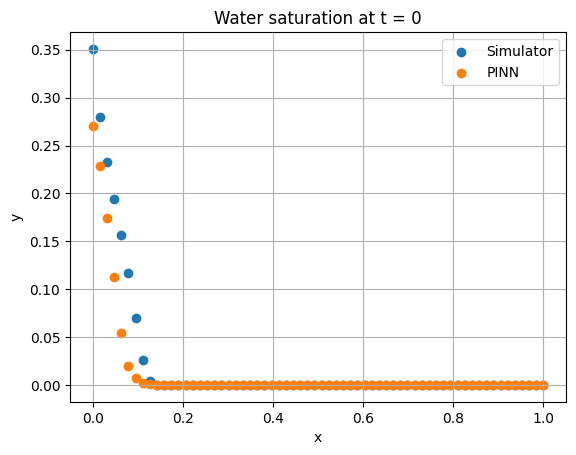

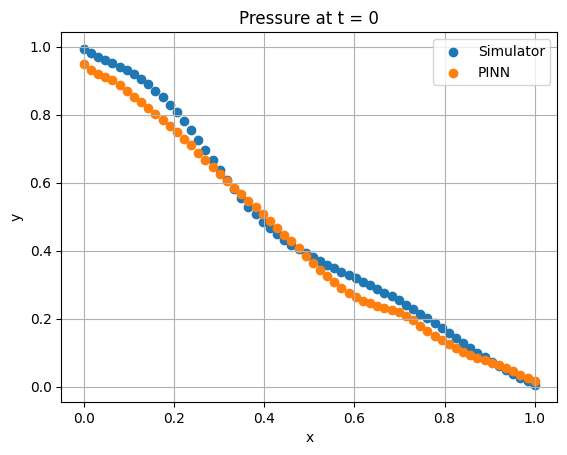

In [29]:
plt.figure()
plt.title('Water saturation, simulator')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Water saturation, PINN')
plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Pressure, simulator')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


plt.figure()
plt.title('Pressure, PINN')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()    


plt.figure()
plt.title('Water saturation at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


plt.figure()
plt.title('Pressure at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()